### Loss Log

| No. | Model                                           | Train Loss | Dev Loss |
| --- | ----------------------------------------------- | ---------- | -------- |
| 1   | Starter Code (From NN v2)                       | 2.125      | 2.172    |
| 2   | Fix initial loss in `softmax`                   | 2.068      | 2.129    |
| 3   | Fix saturated `tanh` layer                      | 2.036      | 2.104    |
| 4   | Fix weight initialization with `kaiming_normal` | 2.036      | 2.106    |

### Final Code

In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [19]:
BLOCK_SIZE = 3
N_EMBED = 10
N_HIDDEN = 200
N_EPOCHS = 200000
BATCH_SIZE = 32

In [20]:
def createWordsMapping(filename = 'names.txt'):
  words = open(filename, 'r').read().splitlines()
  chars = sorted(list(set(''.join(words))))
  stoi = {s:i+1 for i,s in enumerate(chars)}
  stoi['.'] = 0
  itos = {i:s for s,i in stoi.items()}
  n_vocab = len(stoi)
  return words, stoi, itos, n_vocab

words, stoi, itos, n_vocab = createWordsMapping()

In [21]:
def buildDataset(words, block_size):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

def buildDatasets(words, block_size):
  random.seed(42)
  random.shuffle(words)
  
  n1 = int(0.8 * len(words))
  n2 = int(0.9 * len(words))
  
  Xtr, Ytr = buildDataset(words[:n1], block_size)
  Xdev, Ydev = buildDataset(words[n1:n2], block_size)
  Xte, Yte = buildDataset(words[n2:], block_size)

  return Xtr, Ytr, Xdev, Ydev, Xte, Yte

Xtr, Ytr, Xdev, Ydev, Xte, Yte = buildDatasets(words, BLOCK_SIZE)

In [30]:
def initializeWeights(n_vocab, block_size, n_embed, n_hidden):
  g = torch.Generator().manual_seed(2147483647)
  
  C = torch.randn((n_vocab, n_embed), generator=g)
  W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3)/((n_embed*block_size) ** 0.5))
  b1 = torch.randn(n_hidden, generator=g) * 0.01
  W2 = torch.randn((n_hidden, n_vocab), generator=g) * 0.01
  b2 = torch.randn(n_vocab, generator=g) * 0

  parameters = [C, W1, b1, W2, b2]
  for p in parameters:
    p.requires_grad = True

  print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')
  return parameters

parameters = initializeWeights(n_vocab, BLOCK_SIZE, N_EMBED, N_HIDDEN)

Total Parameters: 11897


In [31]:
def trainModel(X, Y, parameters, block_size, n_embed, n_epochs, batch_size):
  C, W1, b1, W2, b2 = parameters
  g = torch.Generator().manual_seed(2147483647)
  lossi = []

  for epoch in range(n_epochs):

    # Minibatch Construct
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X[ix], Y[ix] # batch X, Y 

    # Forward Pass
    emb = C[X_batch] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatentae the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch) # loss function

    # Backward Pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # Update Parameters
    lr = 0.1 if epoch < 100000 else 0.01 # stop learning rate decay
    for p in parameters:
      p.data += -lr * p.grad
    
    # Track Stats
    lossi.append(loss.log10().item())
    if epoch % 10000 == 0:
      print(f'{epoch:7d}/{n_epochs:7d}: {loss.item():.4f}')
  
  trainedParameters = [C, W1, b1, W2, b2]
  return lossi, trainedParameters

lossi, trainedParameters = trainModel(Xtr, Ytr, parameters, BLOCK_SIZE, N_EMBED, N_EPOCHS, BATCH_SIZE)

      0/ 200000: 3.3097
  10000/ 200000: 2.0894
  20000/ 200000: 2.2969
  30000/ 200000: 2.2137
  40000/ 200000: 2.0346
  50000/ 200000: 2.3579
  60000/ 200000: 1.9309
  70000/ 200000: 2.0086
  80000/ 200000: 2.1751
  90000/ 200000: 1.9542
 100000/ 200000: 2.1990
 110000/ 200000: 2.1659
 120000/ 200000: 2.2354
 130000/ 200000: 1.5944
 140000/ 200000: 2.0789
 150000/ 200000: 2.2208
 160000/ 200000: 2.0439
 170000/ 200000: 1.6595
 180000/ 200000: 2.6510
 190000/ 200000: 2.2066


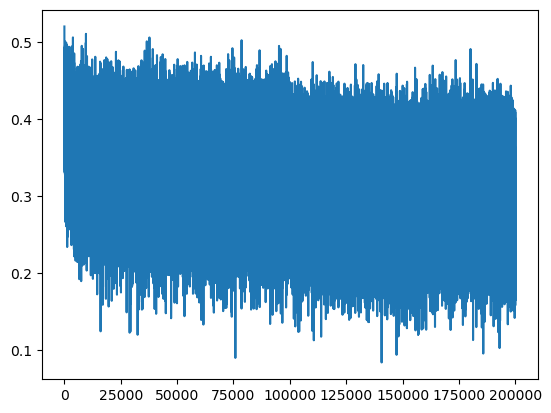

In [32]:
plt.plot(lossi)

In [33]:
@torch.no_grad()
def loss(X, Y, parameters):
  C, W1, b1, W2, b2 = parameters
  emb = C[X]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss

print(f'Train Loss: {loss(Xtr, Ytr, trainedParameters)}')
print(f'Val Loss: {loss(Xdev, Ydev, trainedParameters)}')

Train Loss: 2.0369679927825928
Val Loss: 2.10699200630188


In [34]:
def generateExample(parameters, block_size, g, itos):
  C, W1, b1, W2, b2 = parameters
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])] # (1,block_size, d)
    embcat = emb.view(1, -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  return ''.join(itos[i] for i in out)

def generateExamples(parameters, block_size, itos, numExamples = 20):
  g = torch.Generator().manual_seed(2147483647 + 10)
  examples = []
  for _ in range(numExamples):
    example = generateExample(parameters, block_size, g, itos)
    examples.append(example)
  return examples

generateExamples(trainedParameters, BLOCK_SIZE, itos)

['carmah.',
 'amelle.',
 'khi.',
 'mili.',
 'thil.',
 'skaeson.',
 'jazonel.',
 'deliah.',
 'jareen.',
 'nellara.',
 'chaily.',
 'kaleigh.',
 'ham.',
 'prin.',
 'quint.',
 'shoisea.',
 'jadia.',
 'waython.',
 'jarynn.',
 'jace.']

### 1. Fix the Initial Loss

- Add multiplier of `0.01` and `0` to `W2` and `b2` respectively to reduce high initial loss. The random initialization makes weights have high range of values, thus multiplying by small multipliers make loss smaller in the beginning.
- This also makes model optimize loss better.

In [10]:
# 4 -dimensional example of the issue
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(logits, probs, loss)

logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(logits, probs, loss)

logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(logits, probs, loss)

tensor([0., 5., 0., 0.]) tensor([0.0066, 0.9802, 0.0066, 0.0066]) tensor(5.0200)
tensor([1.3765, 0.5533, 0.7409, 0.2717]) tensor([0.4348, 0.1909, 0.2303, 0.1440]) tensor(1.4685)
tensor([-4.0821, -6.2703,  1.7319, -8.6291]) tensor([2.9757e-03, 3.3360e-04, 9.9666e-01, 3.1538e-05]) tensor(0.0033)


### 2. Fix the Saturated `tanh`

- The solution here is similar to the fixing inital loss. We multiply `W1` by factor of `0.2` and `b1` by factor of `0.01` to reduce overall range of values.

In [15]:
def initializeWeights(n_vocab, block_size, n_embed, n_hidden):
  g = torch.Generator().manual_seed(2147483647)
  
  C = torch.randn((n_vocab, n_embed), generator=g)
  W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
  b1 = torch.randn(n_hidden, generator=g)
  W2 = torch.randn((n_hidden, n_vocab), generator=g) * 0.01
  b2 = torch.randn(n_vocab, generator=g) * 0

  parameters = [C, W1, b1, W2, b2]
  for p in parameters:
    p.requires_grad = True

  print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')
  return parameters

parameters = initializeWeights(n_vocab, BLOCK_SIZE, N_EMBED, N_HIDDEN)

Total Parameters: 11897


In [16]:

n_epochs, batch_size = N_EPOCHS, BATCH_SIZE
X, Y = Xtr, Ytr

C, W1, b1, W2, b2 = parameters
g = torch.Generator().manual_seed(2147483647)
lossi = []

for epoch in range(n_epochs):

  # Minibatch Construct
  ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
  X_batch, Y_batch = X[ix], Y[ix] # batch X, Y 

  # Forward Pass
  emb = C[X_batch] # embed characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatentae the vectors
  hpreact = embcat @ W1 + b1 # hidden layer preactivation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch) # loss function

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update Parameters
  lr = 0.1 if epoch < 100000 else 0.01 # stop learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  
  # Track Stats
  lossi.append(loss.log10().item())
  if epoch % 10000 == 0:
    print(f'{epoch:7d}/{n_epochs:7d}: {loss.item():.4f}')
  
  break

      0/ 200000: 3.3179


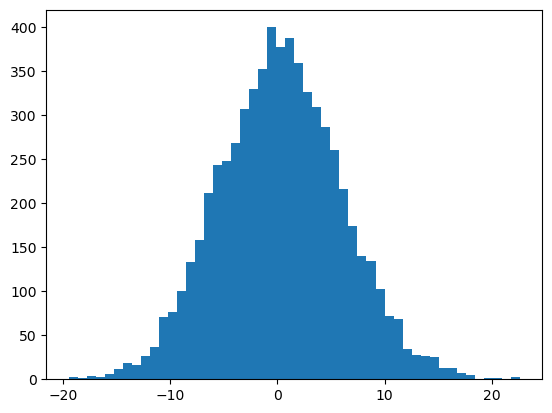

In [17]:
plt.hist(hpreact.view(-1).tolist(), 50);

Distribution of preactivations is very broad `(-20, 20)`. That's why in `torch.tanh()` everything is squashed and capped to be range `(-1, 1)`.

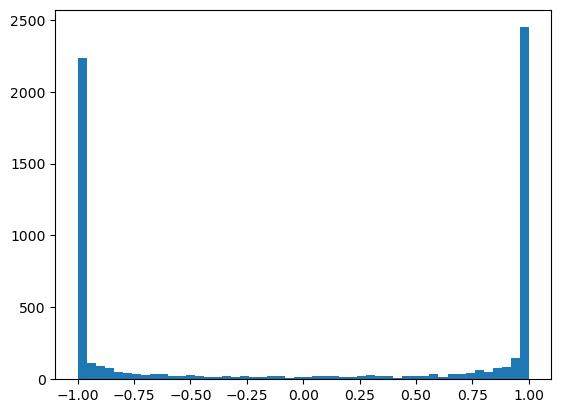

In [18]:
plt.hist(h.view(-1).tolist(), 50);

Most of the values in h take `1` or `-1`, which means this `tanh` activation is very very active.

When `tanh` outputs are close to 1 and -1, considering how we backpropagate in `tanh`:

```python
x = self.data
t = (math.exp(2*x)-1)/(math.exp(2*x)+1)

def _backward():
  self.grad += (1 - t**2) * out.grad
```

We are effectively killing the gradient and stopping the backpropagation, when outputs of `tanh` are close to 1 and -1.

IMP

The gradient passing through `tanh` **can only ever decrease**, considering we are multiplying by the factor of `1 - t**2`. If `t==0`, we are passing `out.grad` as it is, for any other value of `t`, the gradient will decrease.

CONCERN

The problem here is if all of this outputs `h` are in flat region, that is close to `1` or `-1`, the gradient flowing throgh network will get destroyed.

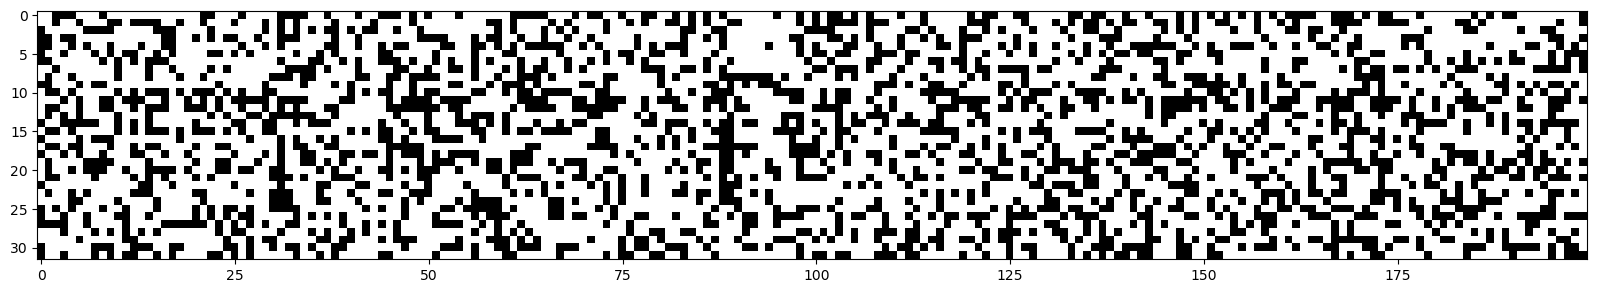

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

White neurons are the ones in the flat domain i.e close to 1 or -1. In all this cases, backward gradient will get destroyed. The issue is when in any one of this 200 neurons, entire column is white, that will be a `dead neuron`, which will never learn. Not a case here.

This is also true for other activation functions as well.

Only issue that we have now is `hpreact` distribution it too wide, causing this neurons to be close to `1` or `-1` after applying `tanh` activation.

**The solution here is similar to the fixing inital loss. We multiply `W1` by factor of `0.2` and `b1` by factor of `0.01` to reduce overall range of values.**

In [25]:
def initializeWeights(n_vocab, block_size, n_embed, n_hidden):
  g = torch.Generator().manual_seed(2147483647)
  
  C = torch.randn((n_vocab, n_embed), generator=g)
  W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2
  b1 = torch.randn(n_hidden, generator=g) * 0.01
  W2 = torch.randn((n_hidden, n_vocab), generator=g) * 0.01
  b2 = torch.randn(n_vocab, generator=g) * 0

  parameters = [C, W1, b1, W2, b2]
  for p in parameters:
    p.requires_grad = True

  print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')
  return parameters

parameters = initializeWeights(n_vocab, BLOCK_SIZE, N_EMBED, N_HIDDEN)

Total Parameters: 11897


In [26]:

n_epochs, batch_size = N_EPOCHS, BATCH_SIZE
X, Y = Xtr, Ytr

C, W1, b1, W2, b2 = parameters
g = torch.Generator().manual_seed(2147483647)
lossi = []

for epoch in range(n_epochs):

  # Minibatch Construct
  ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
  X_batch, Y_batch = X[ix], Y[ix] # batch X, Y 

  # Forward Pass
  emb = C[X_batch] # embed characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatentae the vectors
  hpreact = embcat @ W1 + b1 # hidden layer preactivation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch) # loss function

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update Parameters
  lr = 0.1 if epoch < 100000 else 0.01 # stop learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  
  # Track Stats
  lossi.append(loss.log10().item())
  if epoch % 10000 == 0:
    print(f'{epoch:7d}/{n_epochs:7d}: {loss.item():.4f}')
  
  break

      0/ 200000: 3.3070


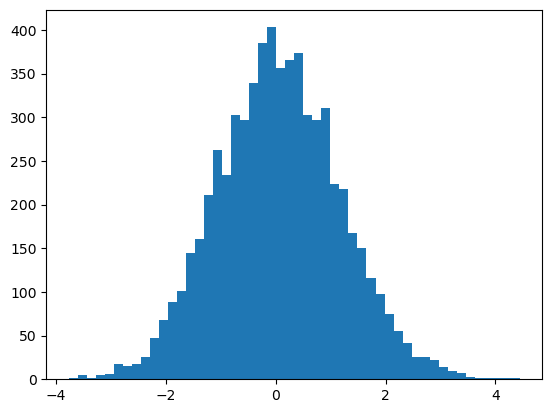

In [27]:
plt.hist(hpreact.view(-1).tolist(), 50);

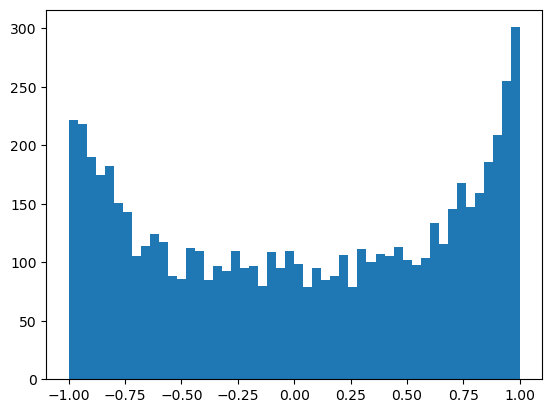

In [28]:
plt.hist(h.view(-1).tolist(), 50);

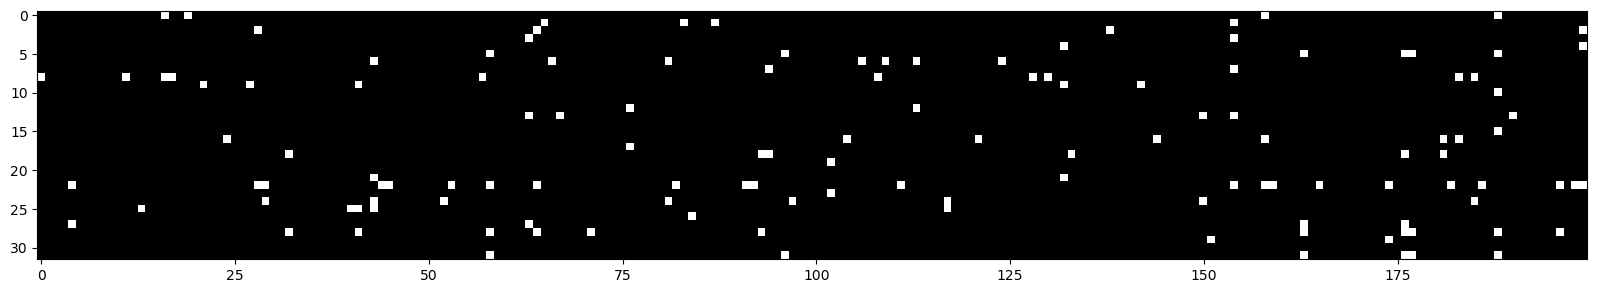

In [29]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### 3. Calculating the init scale: "Kaiming init"

- Set standard deviation of weight initialization to `gain/sqrt(neurons_in)`, hwre `gain` is `5/3` for `tanh`. This is achieved just by multiplying randomly generated weights by this value.

tensor(-0.0026) tensor(0.9972)
tensor(0.0051) tensor(3.1429)


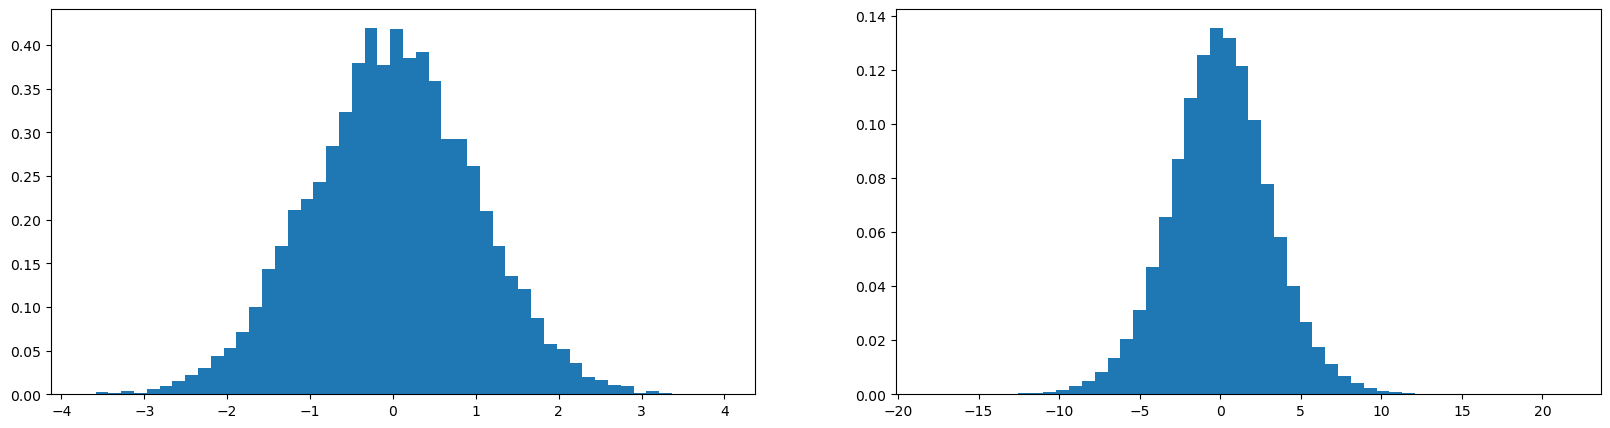

In [27]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

We can see that although `y` has similar 0 mean to `x`, the standard deviation is much higher, giving wider distribution to the `y`.

We want most of the activations to have unit gaussian distribution.

To solve this issue, we need to multiply weights `w` to scale them in a way that makes the activations have unit gaussian distribution. 

Say,
`n = number of input neurons to the layer (fan in)`

- For `tanh`: Multiply the weights by `sqrt(5/3n)`
- For `relu`: Multiply the weights by `sqrt(2/n)`, the factor of 2 is to compensate for the fact that relu squaches negative weights to zero completely

Implemented in PyTorch using `torch.nn.init.kaiming_nomral_`

tensor(0.0058) tensor(0.9907)
tensor(0.0068) tensor(0.9888)


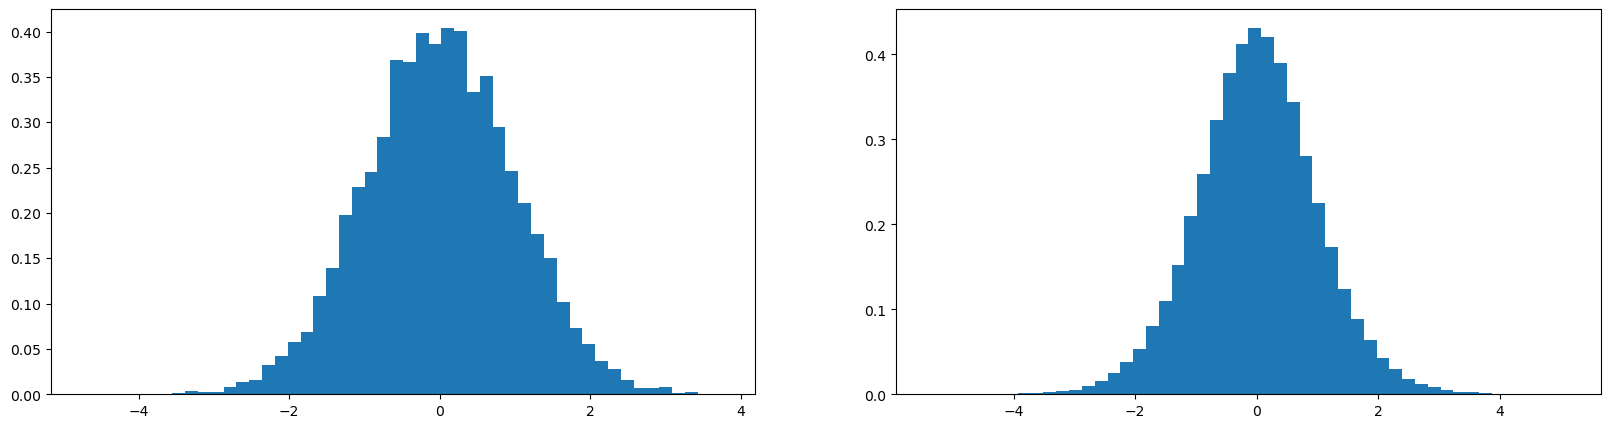

In [28]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10 ** 0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

To achieve this in our neural network, we need to set standard deviation of weight initialization to `gain/sqrt(neurons_in)`, hwre `gain` is `5/3` for `tanh`. This is achieved just by multiplying randomly generated weights by this value.

tensor(0.0068) tensor(1.0073)
tensor(0.0092) tensor(1.6455)


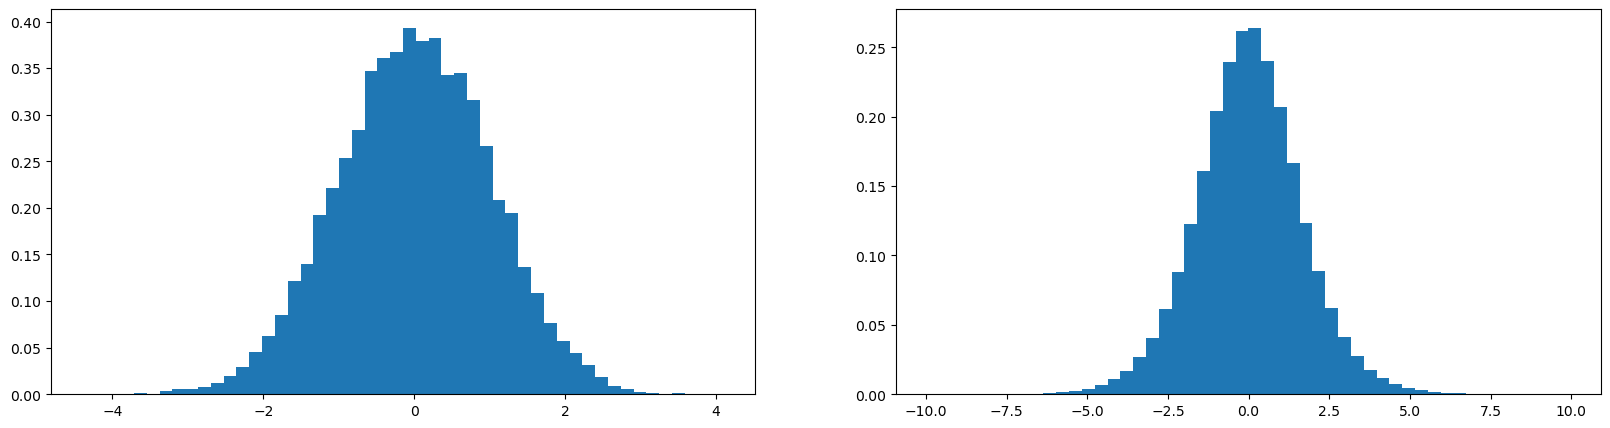

In [29]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * ((5/3) / (10 ** 0.5))
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

### 4. Batch Normalization